<a href="https://colab.research.google.com/github/JhoelHairton/Aplicativo-Demo/blob/main/datamart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

# Sube los 3 archivos
from google.colab import files
print("📂 Sube los 3 archivos CSV del ETL:")
uploaded = files.upload()

# Cargar cada archivo
df_clean = pd.read_csv('telco_churn_clean.csv')
df_numeric = pd.read_csv('telco_churn_numeric.csv')
df_categorical = pd.read_csv('telco_churn_categorical.csv')

print("✅ Archivos cargados:")
print(f"   • df_clean: {df_clean.shape}")
print(f"   • df_numeric: {df_numeric.shape}")
print(f"   • df_categorical: {df_categorical.shape}")

📂 Sube los 3 archivos CSV del ETL:


Saving telco_churn_categorical.csv to telco_churn_categorical.csv
Saving telco_churn_clean.csv to telco_churn_clean.csv
Saving telco_churn_numeric.csv to telco_churn_numeric.csv
✅ Archivos cargados:
   • df_clean: (7043, 26)
   • df_numeric: (7043, 6)
   • df_categorical: (7043, 21)


# DIMENSIÓN 1 - dim_customer

In [3]:
dim_customer = df_clean[['customerID', 'gender', 'SeniorCitizen',
                          'Partner', 'Dependents']].copy()

# Agregar ID único
dim_customer.insert(0, 'customer_key', range(1, len(dim_customer) + 1))

print("✅ dim_customer creada:", dim_customer.shape)
display(dim_customer.head())

✅ dim_customer creada: (7043, 6)


,customer_key,customerID,gender,SeniorCitizen,Partner,Dependents
0,1,7590-VHVEG,Female,No,Yes,No
1,2,5575-GNVDE,Male,No,No,No
2,3,3668-QPYBK,Male,No,No,No
3,4,7795-CFOCW,Male,No,No,No
4,5,9237-HQITU,Female,No,No,No


# DIMENSIÓN 2 - dim_service

In [4]:
dim_service = df_clean[['customerID', 'InternetService', 'PhoneService',
                         'OnlineSecurity', 'OnlineBackup', 'TechSupport',
                         'StreamingTV', 'StreamingMovies', 'ServiceLevel']].copy()

dim_service.insert(0, 'service_key', range(1, len(dim_service) + 1))

print("✅ dim_service creada:", dim_service.shape)
display(dim_service.head())

✅ dim_service creada: (7043, 10)


,service_key,customerID,InternetService,PhoneService,OnlineSecurity,OnlineBackup,TechSupport,StreamingTV,StreamingMovies,ServiceLevel
0,1,7590-VHVEG,DSL,No,No,Yes,No,No,No,Básico
1,2,5575-GNVDE,DSL,Yes,Yes,No,No,No,No,Básico
2,3,3668-QPYBK,DSL,Yes,Yes,Yes,No,No,No,Básico
3,4,7795-CFOCW,DSL,No,Yes,No,Yes,No,No,Premium
4,5,9237-HQITU,Fiber optic,Yes,No,No,No,No,No,Sin servicios


# DIMENSIÓN 3 - dim_contract

In [5]:
dim_contract = df_clean[['customerID', 'Contract', 'PaperlessBilling',
                          'PaymentMethod', 'TenureGroup']].copy()

dim_contract.insert(0, 'contract_key', range(1, len(dim_contract) + 1))

print("✅ dim_contract creada:", dim_contract.shape)
display(dim_contract.head())

✅ dim_contract creada: (7043, 6)


,contract_key,customerID,Contract,PaperlessBilling,PaymentMethod,TenureGroup
0,1,7590-VHVEG,Month-to-month,Yes,Electronic check,0-1 año
1,2,5575-GNVDE,One year,No,Mailed check,2-4 años
2,3,3668-QPYBK,Month-to-month,Yes,Mailed check,0-1 año
3,4,7795-CFOCW,One year,No,Bank transfer (automatic),2-4 años
4,5,9237-HQITU,Month-to-month,Yes,Electronic check,0-1 año


# TABLA DE HECHOS - fact_churn

In [6]:
fact_churn = pd.DataFrame({
    # Claves
    'customer_key': range(1, len(df_clean) + 1),
    'service_key': range(1, len(df_clean) + 1),
    'contract_key': range(1, len(df_clean) + 1),

    # Métricas
    'tenure': df_clean['tenure'],
    'monthly_charges': df_clean['MonthlyCharges'],
    'total_charges': df_clean['TotalCharges'],
    'avg_monthly_spend': df_clean['AvgMonthlySpend'],
    'total_services': df_clean['TotalServices'],

    # Flags
    'churn': df_clean['Churn_Binary'],
    'is_active': (df_clean['Churn'] == 'No').astype(int)
})

# Calcular CLV (Customer Lifetime Value)
fact_churn['customer_lifetime_value'] = (
    fact_churn['monthly_charges'] * fact_churn['tenure']
)

print("✅ fact_churn creada:", fact_churn.shape)
print(f"\n📊 Métricas:")
print(f"   Total clientes: {len(fact_churn):,}")
print(f"   Con Churn: {fact_churn['churn'].sum():,}")
print(f"   Activos: {fact_churn['is_active'].sum():,}")
display(fact_churn.head())

✅ fact_churn creada: (7043, 11)

📊 Métricas:
   Total clientes: 7,043
   Con Churn: 1,869
   Activos: 5,174


,customer_key,service_key,contract_key,tenure,monthly_charges,total_charges,avg_monthly_spend,total_services,churn,is_active,customer_lifetime_value
0,1,1,1,1,29.85,29.85,14.925000,1,0,1,29.85
1,2,2,2,34,56.95,1889.50,53.985714,2,0,1,1936.30
2,3,3,3,2,53.85,108.15,36.050000,2,1,0,107.70
3,4,4,4,45,42.30,1840.75,40.016304,3,0,1,1903.50
4,5,5,5,2,70.70,151.65,50.550000,0,1,0,141.40


#  AGREGADO 1 - Por Tipo de Contrato

In [7]:
# Unir fact con dimensiones
fact_full = fact_churn.merge(dim_contract[['contract_key', 'Contract']],
                              on='contract_key')
fact_full = fact_full.merge(dim_service[['service_key', 'ServiceLevel']],
                            on='service_key')

# Agregar por contrato
agg_by_contract = fact_full.groupby('Contract').agg({
    'customer_key': 'count',
    'churn': ['sum', 'mean'],
    'monthly_charges': 'mean',
    'total_charges': 'sum',
    'tenure': 'mean',
    'customer_lifetime_value': 'mean'
}).round(2)

agg_by_contract.columns = ['total_customers', 'churn_count', 'churn_rate',
                            'avg_monthly', 'total_revenue', 'avg_tenure', 'avg_clv']
agg_by_contract = agg_by_contract.reset_index()
agg_by_contract['churn_pct'] = (agg_by_contract['churn_rate'] * 100).round(2)

print("✅ agg_by_contract creada")
display(agg_by_contract)

✅ agg_by_contract creada


,Contract,total_customers,churn_count,churn_rate,avg_monthly,total_revenue,avg_tenure,avg_clv,churn_pct
0,Month-to-month,3875,1655,0.43,66.40,5305861.5,18.04,1370.12,43.0
1,One year,1473,166,0.11,65.05,4467073.2,42.04,3029.83,11.0
2,Two year,1695,48,0.03,60.77,6283689.6,56.74,3706.76,3.0


# AGREGADO 2 - Por Nivel de Servicio

In [8]:
agg_by_service = fact_full.groupby('ServiceLevel').agg({
    'customer_key': 'count',
    'churn': ['sum', 'mean'],
    'monthly_charges': ['mean', 'min', 'max'],
    'total_charges': 'sum',
    'tenure': 'mean',
    'total_services': 'mean'
}).round(2)

agg_by_service.columns = ['total_customers', 'churn_count', 'churn_rate',
                          'avg_monthly', 'min_monthly', 'max_monthly',
                          'total_revenue', 'avg_tenure', 'avg_services']
agg_by_service = agg_by_service.reset_index()
agg_by_service['churn_pct'] = (agg_by_service['churn_rate'] * 100).round(2)

print("✅ agg_by_service creada")
display(agg_by_service)

✅ agg_by_service creada


,ServiceLevel,total_customers,churn_count,churn_rate,avg_monthly,min_monthly,max_monthly,total_revenue,avg_tenure,avg_services,churn_pct
0,Básico,1999,812,0.41,69.11,28.45,97.65,3020852.00,21.61,1.52,41.0
1,Premium,2825,582,0.21,86.80,37.70,118.75,11602999.75,46.46,4.01,21.0
2,Sin servicios,2219,475,0.21,32.79,18.25,77.90,1432772.55,24.13,0.00,21.0


# AGREGADO 3 - KPIs Principales

In [9]:
kpis = pd.DataFrame({
    'KPI': [
        'Total Clientes',
        'Clientes con Churn',
        'Clientes Activos',
        'Tasa de Churn (%)',
        'Tasa de Retención (%)',
        'Revenue Total ($)',
        'Revenue Promedio ($)',
        'Tenure Promedio (meses)',
        'CLV Promedio ($)',
        'Cargo Mensual Promedio ($)'
    ],
    'Valor': [
        len(fact_churn),
        fact_churn['churn'].sum(),
        fact_churn['is_active'].sum(),
        round(fact_churn['churn'].mean() * 100, 2),
        round((1 - fact_churn['churn'].mean()) * 100, 2),
        round(fact_churn['total_charges'].sum(), 2),
        round(fact_churn['total_charges'].mean(), 2),
        round(fact_churn['tenure'].mean(), 2),
        round(fact_churn['customer_lifetime_value'].mean(), 2),
        round(fact_churn['monthly_charges'].mean(), 2)
    ]
})

print("✅ KPIs creados")
display(kpis)


✅ KPIs creados


,KPI,Valor
0,Total Clientes,7043.00
1,Clientes con Churn,1869.00
2,Clientes Activos,5174.00
3,Tasa de Churn (%),26.54
4,Tasa de Retención (%),73.46
5,Revenue Total ($),16056624.30
6,Revenue Promedio ($),2279.80
7,Tenure Promedio (meses),32.37
8,CLV Promedio ($),2279.58
9,Cargo Mensual Promedio ($),64.76


# EXPORTAR DATA MART A EXCEL


In [10]:
!pip install openpyxl -q

# Crear Excel con todas las tablas
filename = 'DataMart_Telco_Churn.xlsx'

with pd.ExcelWriter(filename, engine='openpyxl') as writer:
    # Dimensiones
    dim_customer.to_excel(writer, sheet_name='dim_customer', index=False)
    dim_service.to_excel(writer, sheet_name='dim_service', index=False)
    dim_contract.to_excel(writer, sheet_name='dim_contract', index=False)

    # Hechos
    fact_churn.to_excel(writer, sheet_name='fact_churn', index=False)

    # Agregados
    agg_by_contract.to_excel(writer, sheet_name='agg_contract', index=False)
    agg_by_service.to_excel(writer, sheet_name='agg_service', index=False)
    kpis.to_excel(writer, sheet_name='KPIs', index=False)

print(f"✅ Archivo creado: {filename}")
print(f"📊 Total de hojas: 7")

# Descargar automáticamente
files.download(filename)

✅ Archivo creado: DataMart_Telco_Churn.xlsx
📊 Total de hojas: 7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# VISUALIZACIONES RÁPIDAS


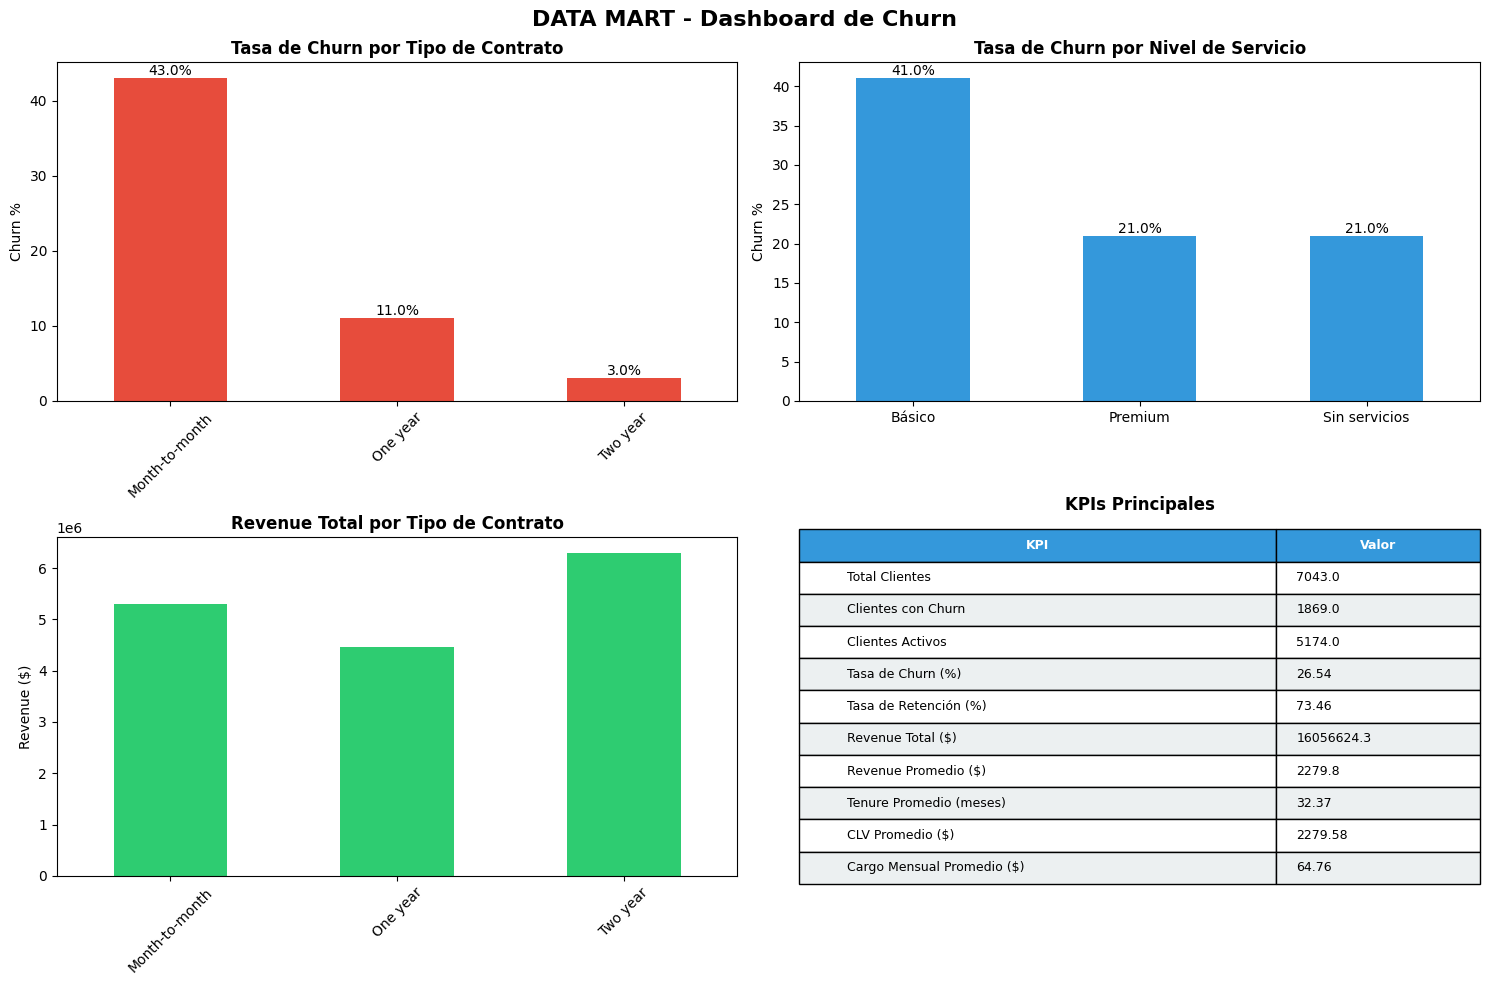

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('DATA MART - Dashboard de Churn', fontsize=16, fontweight='bold')

# 1. Churn por Contrato
agg_by_contract.plot(x='Contract', y='churn_pct', kind='bar',
                     ax=axes[0,0], color='#e74c3c', legend=False)
axes[0,0].set_title('Tasa de Churn por Tipo de Contrato', fontweight='bold')
axes[0,0].set_ylabel('Churn %')
axes[0,0].set_xlabel('')
axes[0,0].tick_params(axis='x', rotation=45)
for container in axes[0,0].containers:
    axes[0,0].bar_label(container, fmt='%.1f%%')

# 2. Churn por Nivel de Servicio
agg_by_service.plot(x='ServiceLevel', y='churn_pct', kind='bar',
                    ax=axes[0,1], color='#3498db', legend=False)
axes[0,1].set_title('Tasa de Churn por Nivel de Servicio', fontweight='bold')
axes[0,1].set_ylabel('Churn %')
axes[0,1].set_xlabel('')
axes[0,1].tick_params(axis='x', rotation=0)
for container in axes[0,1].containers:
    axes[0,1].bar_label(container, fmt='%.1f%%')

# 3. Revenue por Contrato
agg_by_contract.plot(x='Contract', y='total_revenue', kind='bar',
                     ax=axes[1,0], color='#2ecc71', legend=False)
axes[1,0].set_title('Revenue Total por Tipo de Contrato', fontweight='bold')
axes[1,0].set_ylabel('Revenue ($)')
axes[1,0].set_xlabel('')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Tabla de KPIs
axes[1,1].axis('tight')
axes[1,1].axis('off')
table = axes[1,1].table(cellText=kpis.values, colLabels=kpis.columns,
                        cellLoc='left', loc='center', colWidths=[0.7, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
axes[1,1].set_title('KPIs Principales', fontweight='bold', pad=20)

# Colorear tabla
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_facecolor('#3498db')
        cell.set_text_props(weight='bold', color='white')
    else:
        cell.set_facecolor('#ecf0f1' if i % 2 == 0 else 'white')

plt.tight_layout()
plt.show()


# RESUMEN FINAL


In [12]:
print("\n" + "="*70)
print("🎉 DATA MART COMPLETADO")
print("="*70)

print(f"""
📊 ESTRUCTURA CREADA:

┌─────────────────────────────────────────┐
│           TABLAS DIMENSIÓN              │
├─────────────────────────────────────────┤
│ ✓ dim_customer   : {dim_customer.shape[0]:>5} registros      │
│ ✓ dim_service    : {dim_service.shape[0]:>5} registros      │
│ ✓ dim_contract   : {dim_contract.shape[0]:>5} registros      │
└─────────────────────────────────────────┘

┌─────────────────────────────────────────┐
│          TABLA DE HECHOS                │
├─────────────────────────────────────────┤
│ ✓ fact_churn     : {fact_churn.shape[0]:>5} registros      │
│   • {fact_churn.shape[1]} métricas                         │
└─────────────────────────────────────────┘

┌─────────────────────────────────────────┐
│         TABLAS AGREGADAS                │
├─────────────────────────────────────────┤
│ ✓ agg_by_contract: {len(agg_by_contract)} categorías          │
│ ✓ agg_by_service : {len(agg_by_service)} niveles             │
│ ✓ KPIs           : {len(kpis)} métricas             │
└─────────────────────────────────────────┘

📁 ARCHIVO EXPORTADO:
   • DataMart_Telco_Churn.xlsx

🎯 INSIGHTS CLAVE:
   • Tasa de Churn: {kpis.loc[kpis['KPI']=='Tasa de Churn (%)', 'Valor'].values[0]}%
   • {agg_by_contract.loc[agg_by_contract['churn_pct'].idxmax(), 'Contract']} tiene mayor churn ({agg_by_contract['churn_pct'].max():.1f}%)
   • Revenue total: ${fact_churn['total_charges'].sum():,.2f}
""")

print("="*70)
print("✅ ¡LISTO! Archivo descargado automáticamente")
print("="*70)


🎉 DATA MART COMPLETADO

📊 ESTRUCTURA CREADA:

┌─────────────────────────────────────────┐
│           TABLAS DIMENSIÓN              │
├─────────────────────────────────────────┤
│ ✓ dim_customer   :  7043 registros      │
│ ✓ dim_service    :  7043 registros      │
│ ✓ dim_contract   :  7043 registros      │
└─────────────────────────────────────────┘

┌─────────────────────────────────────────┐
│          TABLA DE HECHOS                │
├─────────────────────────────────────────┤
│ ✓ fact_churn     :  7043 registros      │
│   • 11 métricas                         │
└─────────────────────────────────────────┘

┌─────────────────────────────────────────┐
│         TABLAS AGREGADAS                │
├─────────────────────────────────────────┤
│ ✓ agg_by_contract: 3 categorías          │
│ ✓ agg_by_service : 3 niveles             │
│ ✓ KPIs           : 10 métricas             │
└─────────────────────────────────────────┘

📁 ARCHIVO EXPORTADO:
   • DataMart_Telco_Churn.xlsx

🎯 INSIGHTS C